# Unisolar Projet: Modeling
---

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from matplotlib.dates import HourLocator,DateFormatter

from sklearn.metrics import mean_squared_error, mean_absolute_error
from unisolar_utils import (naive_predictions,
                            plot_naive_predictions,
                            print_naive_predictions_metrics,
                            train_valid_test_split_df,
                            plot_train_valid_test,
                            to_seq2seq_dataset,
                            plot_training_history,
                            plot_random_predictions,
                            prediction_df,
                            create_error_list,
                            plot_errors_horizon)


import tensorflow as tf
from tensorflow.keras.regularizers import l2

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2024-02-10 19:06:43.231586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading data

We load the data saved at the end of the EDA notebook, containing weather features for campus 3 with `SolarGeneration` data from site 10.

In [2]:
df_preprocess = pd.read_csv('preprocessed_data.csv', index_col='Timestamp', parse_dates=['Timestamp'])
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   61343 non-null  float64
 1   AirTemperature    61343 non-null  float64
 2   RelativeHumidity  61343 non-null  float64
 3   WindSpeed         61343 non-null  float64
 4   WindDirection     61343 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


Let's resample the data to 1 hour time steps instead of 15 minutes. I can't think of any real world application in which solar energy generation would be required in 15 minutes time intervals. A 1 hour timescale sounds more interesting to look at, for instance if solar energy forecasts were used in order to set the target output of power plants.

In [3]:
df_preprocess_resampled = df_preprocess.resample('1h').agg({"SolarGeneration": "mean",
                                                            "AirTemperature": "mean",
                                                            "RelativeHumidity": "mean",
                                                            "WindSpeed": "mean",
                                                            "WindDirection": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan})

## Naive Model

We will evaluate our models performances against that of a base, naive model. Since the solar generation follows the natural cycle of the sun, a simple and efficient naive model would simply predict the value observed 24 hours ago. 

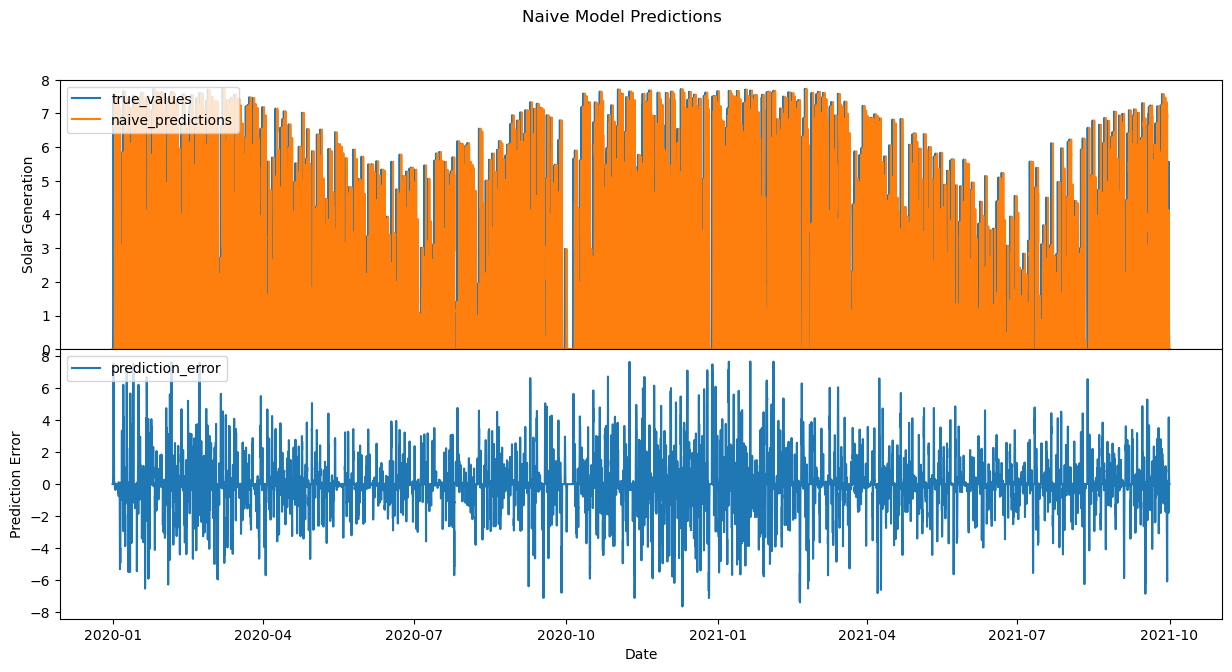

In [4]:
plot_naive_predictions(df_preprocess_resampled)

In [5]:
print_naive_predictions_metrics(df_preprocess_resampled)

Mean Squared Error: 1.6724112201266499
Mean Absolute Error: 0.5878096533483308


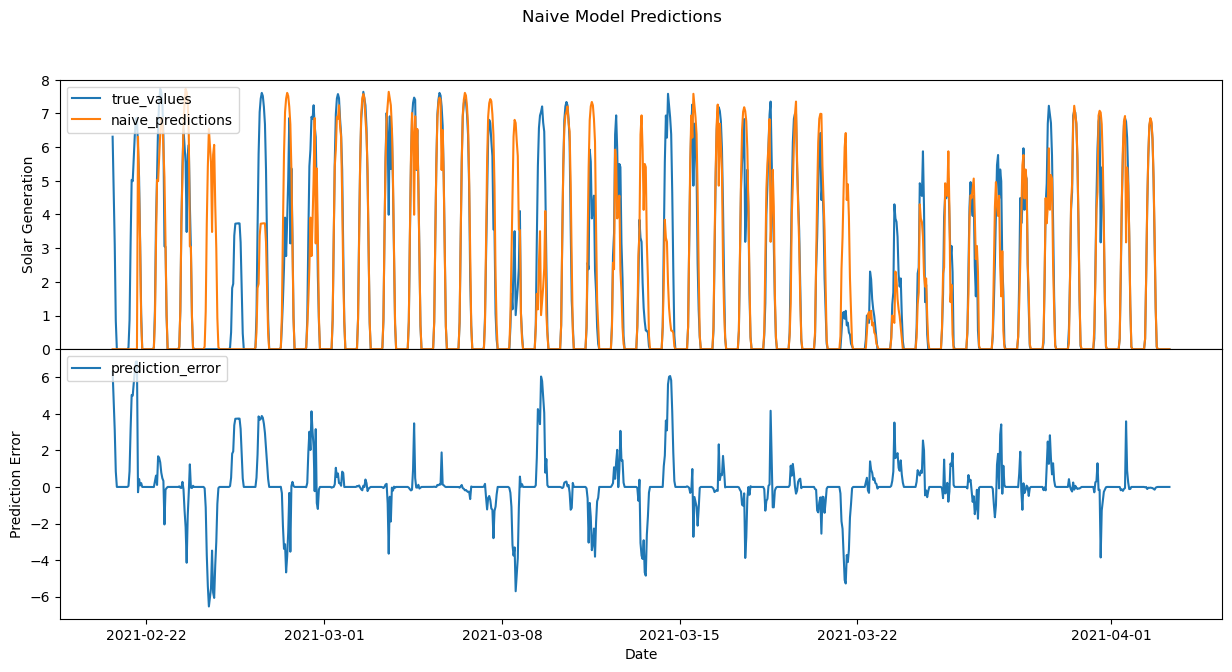

In [6]:
plot_naive_predictions(df_preprocess_resampled[10000:11000])

In [7]:
print_naive_predictions_metrics(df_preprocess_resampled[10000:12000])

Mean Squared Error: 1.7085420761108399
Mean Absolute Error: 0.569470703125


Overall, it looks like the naive model if performing well: if captures by essence the daily and yearly seasonality of the solar generation. Depending on the subset of data used to evaluate the naive model, we find typical values of MAE of 0.56-0.58 and MSE of 1.6-1.7.

## Feature Engineering

We will do some feature engineering on the preprocessed data to improve model performance.

Let's create seasonal features to represent the daily and yearly periodicity of the solar generation. As the solar generation over one day is periodic but does not follow a simple sinusoidal function, we add a couple harmonics to improve predictions.

#### Seasonal Features

In [8]:
harmonics=3
for h in range(harmonics):
    h += 1
    df_preprocess_resampled[f'day_sine{h}'] = np.sin(df_preprocess_resampled.index.hour/24*2*np.pi*h)
    df_preprocess_resampled[f'day_cosine{h}'] = np.cos(df_preprocess_resampled.index.hour/24*2*np.pi*h)

In [9]:
df_preprocess_resampled['year_sine'] = np.sin(df_preprocess_resampled.index.dayofyear/365*2*np.pi)
df_preprocess_resampled['year_cosine'] = np.cos(df_preprocess_resampled.index.dayofyear/365*2*np.pi)

#### Wind Features

Angles are not easily understood by ML algorithms. Let's encode the `WindSpeed` and `WindDirection` as a `WindVector` with two coordinates:

In [10]:
df_preprocess_resampled['WindX'] = np.cos(df_preprocess_resampled['WindDirection']/360*2*np.pi)*df_preprocess_resampled['WindSpeed']
df_preprocess_resampled['WindY'] = np.sin(df_preprocess_resampled['WindDirection']/360*2*np.pi)*df_preprocess_resampled['WindSpeed']
df_preprocess_resampled = df_preprocess_resampled.drop(columns=['WindDirection','WindSpeed'])

#### Other Features

The other features: `AirTemperature` and `RelativeHumidity` are simple enough to be used in the model as they are.

In [11]:
df_preprocess_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15336 entries, 2020-01-01 00:00:00 to 2021-09-30 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   15336 non-null  float64
 1   AirTemperature    15336 non-null  float64
 2   RelativeHumidity  15336 non-null  float64
 3   day_sine1         15336 non-null  float64
 4   day_cosine1       15336 non-null  float64
 5   day_sine2         15336 non-null  float64
 6   day_cosine2       15336 non-null  float64
 7   day_sine3         15336 non-null  float64
 8   day_cosine3       15336 non-null  float64
 9   year_sine         15336 non-null  float64
 10  year_cosine       15336 non-null  float64
 11  WindX             15336 non-null  float64
 12  WindY             15336 non-null  float64
dtypes: float64(13)
memory usage: 1.6 MB


## Train Test Split

We will first create a simple train/validation/test split of the data. We will train the model on the first year of data, so that it can learn the yearly seasonality, then validate it on the next 6 months, and keep the last 6 months for assessing the model's performance.

In [12]:
df_train, df_valid, df_test = train_valid_test_split_df(df_preprocess_resampled, "2021-01", "2021-06")

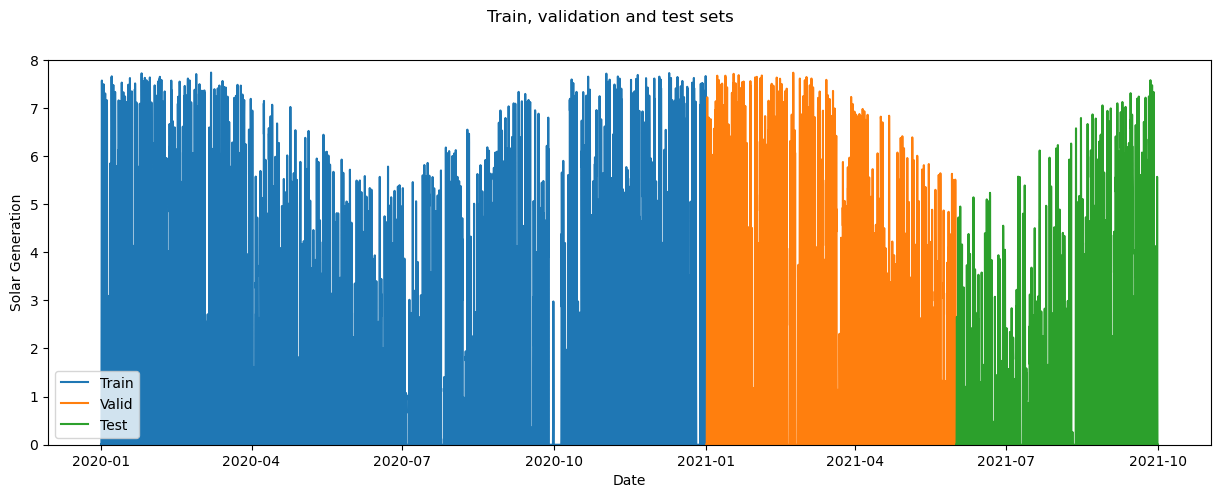

In [13]:
plot_train_valid_test(df_train, df_valid, df_test)

The lack of data around 2020-10 is probably the reason why our models will usually perform better on the validation set than on the training set.

## Preprocessing

We only need to apply  `StandardScaler` to the numerical features and leave the target columns `SolarGeneration` untouched.

In [14]:
categorical_features = list(df_preprocess_resampled.select_dtypes(include='category').columns)

column_transformer = ColumnTransformer([
    ('target', 'passthrough', ['SolarGeneration',])],
    remainder=StandardScaler()
)

We fit the transformer to the train set only, and transform the whole dataset.

In [15]:
df_train_transf = column_transformer.fit_transform(df_train)
df_valid_transf = column_transformer.transform(df_valid)
df_test_transf = column_transformer.transform(df_test)

## Model Selection

### RNN Model

We will first prepare a recurrent neural network using Gated Recurrent Units (GRU) to predict `SolarGeneration`. We will use the last 7 days of data to forecast the next 24 hours.

In [16]:
prediction_window, training_window = 24, 7*24
n_inputs = df_train_transf.shape[-1]

We prepare the data for a sequence to sequence model outputting a vector of the next 24 hours of `SolarGeneration` at every time step. To do so, we use the function detailed in "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by A. Géron chapter 15. It can also be found on [GitHub](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb).


In [17]:
ds_train = to_seq2seq_dataset(df_train_transf, training_window, prediction_window, 0, shuffle=True)
ds_valid = to_seq2seq_dataset(df_valid_transf, training_window, prediction_window, 0)
ds_test = to_seq2seq_dataset(df_test_transf, training_window, prediction_window, 0)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-02-10 19:06:59.262033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


We set the optimizer and callbacks for our model. We will save our model parameters to avoid rerunning it every time.

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

rnn_checkpoint_path = 'model/rnn/rnn_{epoch:04d}'
rnn_checkpoint_dir = os.path.dirname(rnn_checkpoint_path)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
rnn_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=rnn_checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

rnn_callbacks = [early_stopping, rnn_checkpoint]


This model was chosen by varying the parameters (number and type of layers, units and regularization), training the model using GPU of Kaggle notebooks and comparing the results. Here we will use a model that performed well while being simple enough to be trained on CPU in around 10 minutes.

In [19]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=[training_window, n_inputs], return_sequences=True, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(prediction_window, activation='relu')])

rnn_model.compile(optimizer=optimizer, loss='mae', metrics=['mae','mse',])

In [20]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 168, 128)          54912     
                                                                 
 dropout (Dropout)           (None, 168, 128)          0         
                                                                 
 dense (Dense)               (None, 168, 64)           8256      
                                                                 
 dropout_1 (Dropout)         (None, 168, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 168, 24)           1560      
                                                                 
Total params: 64,728
Trainable params: 64,728
Non-trainable params: 0
_________________________________________________________________


We can load the model's best parameters from the `model\rnn` directory.

In [21]:
latest = tf.train.latest_checkpoint(rnn_checkpoint_dir)
rnn_model.load_weights(latest)

In [22]:
# rnn_history = rnn_model.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=rnn_callbacks)
# plot_training_history(rnn_history,'RNN_history')

Now we can predict `SolarGeneration` from the validation dataset and build a dataframe containing for each moment, the predictions and labels for each hour and forecast horizon (1 hour up to 24 hours).

In [23]:
rnn_predictions = rnn_model.predict(ds_valid)
prediction_df_rnn = prediction_df(rnn_predictions, df_valid, prediction_window, training_window)

108/108 [==============================] - 5s 43ms/step


We can take a look at a few random predictions, along with the label and naive prediction.

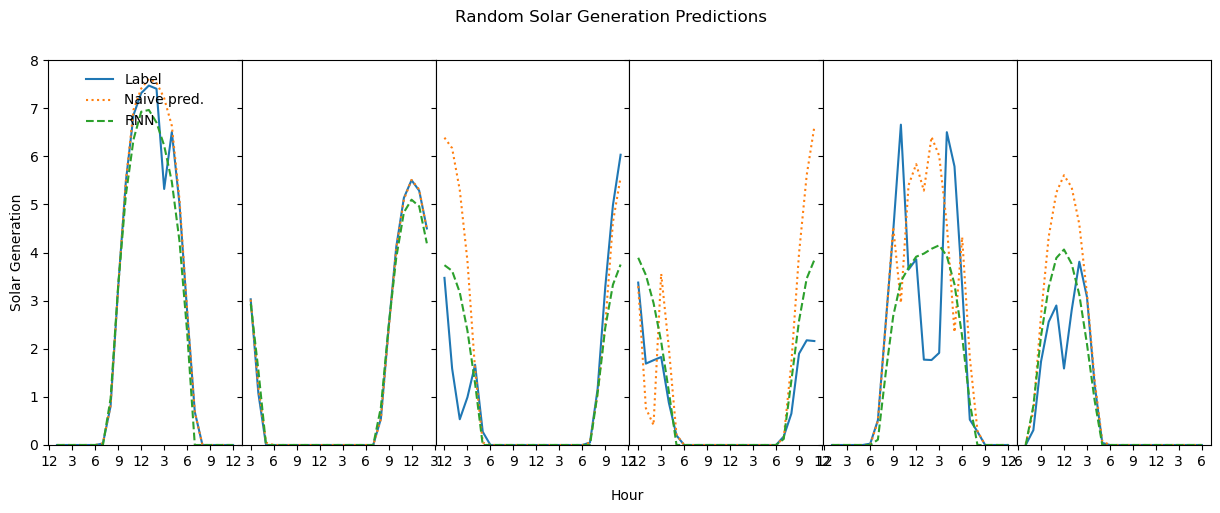

In [24]:
plot_random_predictions(df_valid, {'RNN':rnn_predictions}, training_window, prediction_window)

We can also evaluate the model performance on the training dataset.

In [25]:
rnn_mae, rnn_mse = create_error_list(prediction_df_rnn, prediction_window)
print('RNN model')
print(f'Mean Squared Error: {np.mean(rnn_mse)}')
print(f'Mean Absolute Error: {np.mean(rnn_mae)}\n')
print('Naive Model')
print_naive_predictions_metrics(df_valid)

RNN model
Mean Squared Error: 1.1301319734207311
Mean Absolute Error: 0.5027835585379382

Naive Model
Mean Squared Error: 1.9562271615001012
Mean Absolute Error: 0.6369914545391833


Our model is performing better than the naive model according to MAE and MSE. It seems that our model is better at avoiding large error resulting in large MSE

We can also look at the same metrics for each prediction horizons (1 hour ahead up to 24 hours ahead):

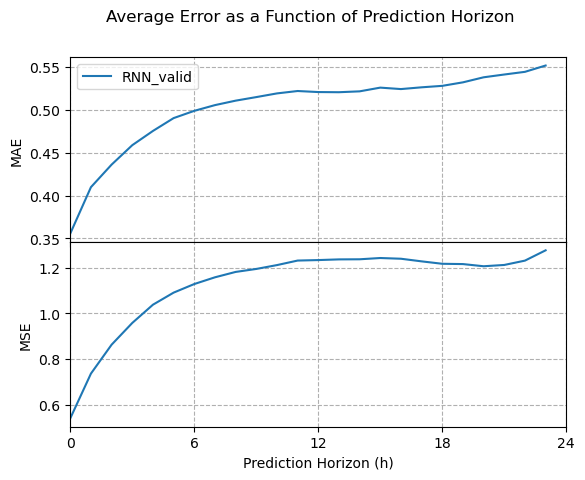

In [26]:
error_dict ={'RNN_valid': [rnn_mae, rnn_mse]}
plot_errors_horizon(error_dict)

Unsurprisingly, the model's performance decreases the further ahead in time we look. The MAE and MSE are smaller than that of the naive model for every forecast horizon.

### CNN Model

We will now train a CNN model, hoping to improve the prediction performance. 

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_checkpoint_path = 'model/cnn/cnn_{epoch:04d}'
cnn_checkpoint_dir = os.path.dirname(cnn_checkpoint_path)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

cnn_callbacks = [early_stopping, cnn_checkpoint]

In [28]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 4, input_shape=[training_window, n_inputs], padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1D(64, 4, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1D(128, 4, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Dense(prediction_window, activation='relu')
])

cnn_model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

In [29]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 32)           1696      
                                                                 
 dropout_2 (Dropout)         (None, 168, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 168, 64)           8256      
                                                                 
 dropout_3 (Dropout)         (None, 168, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 168, 128)          32896     
                                                                 
 dropout_4 (Dropout)         (None, 168, 128)          0         
                                                                 
 dense_2 (Dense)             (None, 168, 24)          

In [30]:
latest = tf.train.latest_checkpoint(cnn_checkpoint_dir)
cnn_model.load_weights(latest)

In [31]:
# cnn_history = cnn_model.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=cnn_callbacks)
# plot_training_history(cnn_history,'CNN_history')

Predicting on the same validation dataset

In [32]:
cnn_predictions = cnn_model.predict(ds_valid)
prediction_df_cnn = prediction_df(cnn_predictions, df_valid, prediction_window, training_window)

108/108 [==============================] - 2s 19ms/step


Potting a few 24h predictions for each model:

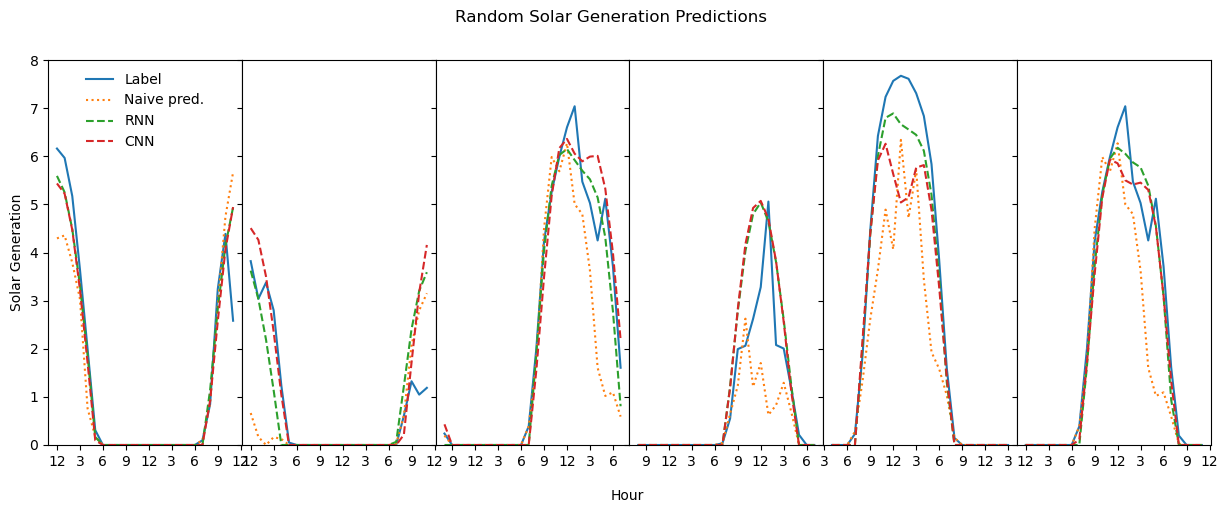

In [33]:
plot_random_predictions(df_valid, {'RNN':rnn_predictions, 'CNN':cnn_predictions}, training_window, prediction_window)

It seems that the CNN model does a better job at finding the sudden variations in `SolarGeneration`.

In [34]:
cnn_mae, cnn_mse = create_error_list(prediction_df_cnn, prediction_window)
print('CNN model')
print(f'Mean Squared Error: {np.mean(cnn_mse)}')
print(f'Mean Absolute Error: {np.mean(cnn_mae)}')

CNN model
Mean Squared Error: 1.0632892103072906
Mean Absolute Error: 0.49929404151430545


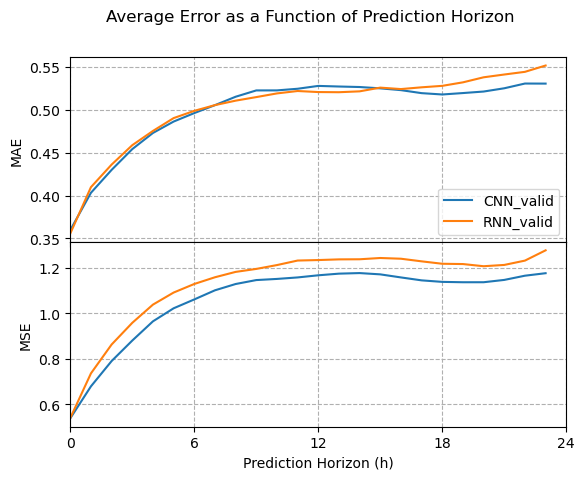

In [35]:
error_dict ={'CNN_valid': [cnn_mae, cnn_mse], 'RNN_valid': [rnn_mae, rnn_mse]}
plot_errors_horizon(error_dict)

The CNN model performs slightly better than the RNN on almost every aspect the RNN. THe lower MSE for every prediction horizon confirms the observation we made on the ability of this model to adapt to sudden change in solar generation, avoiding large error. We will select this model for predictions and will assess its performance 

## Model Assessment 

We've kept a fraction of the data in `ds_test` that was not used in the training process to determine how well the CNN model generalize.

In [36]:
cnn_predictions_test = cnn_model.predict(ds_test)
prediction_df_cnn_test = prediction_df(cnn_predictions_test, df_test, prediction_window, training_window)

86/86 [==============================] - 2s 20ms/step


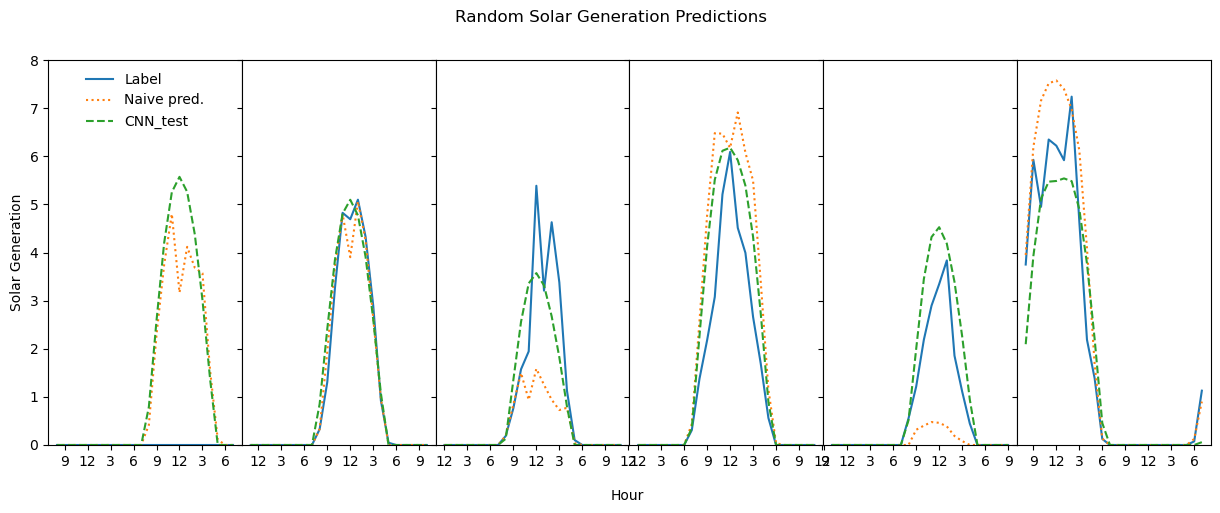

In [55]:
plot_random_predictions(df_test, {'CNN_test':cnn_predictions_test}, training_window, prediction_window)

In [38]:
cnn_mae_test, cnn_mse_test = create_error_list(prediction_df_cnn_test, prediction_window)
print('Naive Model')
print_naive_predictions_metrics(df_test)
print('\nCNN model test')
print(f'Mean Squared Error: {np.mean(cnn_mse_test)}')
print(f'Mean Absolute Error: {np.mean(cnn_mae_test)}')

Naive Model
Mean Squared Error: 1.1351378237614866
Mean Absolute Error: 0.47896788550204916

CNN model test
Mean Squared Error: 0.8704211104026022
Mean Absolute Error: 0.43964380883592674


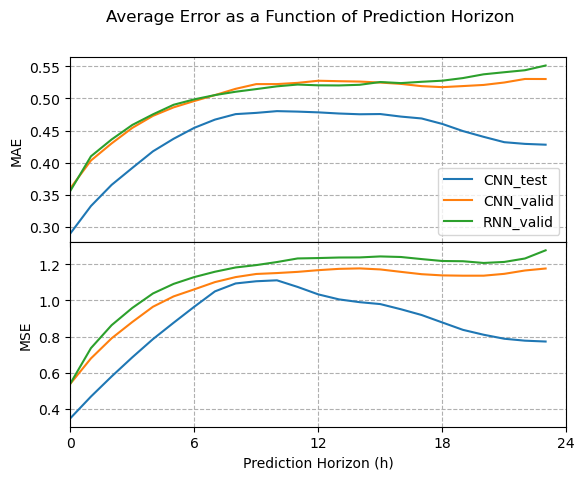

In [39]:
error_dict ={'CNN_test': [cnn_mae_test, cnn_mse_test], 'CNN_valid': [cnn_mae, cnn_mse], 'RNN_valid': [rnn_mae, rnn_mse]}
plot_errors_horizon(error_dict)

Our model performs nicely on the test dataset!